# Estimate parameters of sine wave

In [1]:
import jax
from jax import jit
import jax.numpy as jnp
import jax.random as jr
# import jax.scipy as js

import numpy as np
import matplotlib.pyplot as plt
import corner

# Make fake data

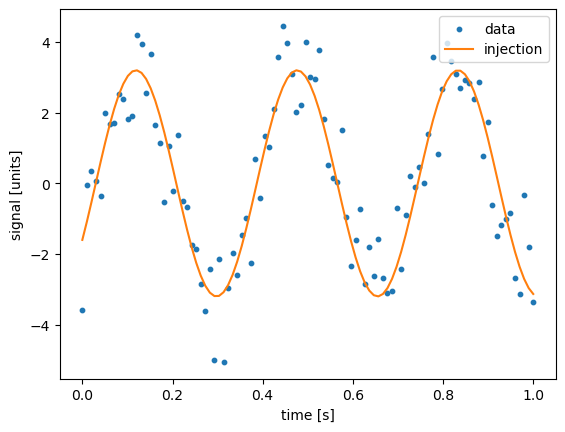

In [2]:
# time samples for data collection
t_start = 0.
t_stop = 1.
Nt = 100
times = jnp.linspace(t_start, t_stop, Nt)

# model data as sinusoid
def model(amp, freq, phase):
    return amp * jnp.sin(2. * jnp.pi * freq * times - phase)

# noise is drawn from zero-mean normal distribution
noise_stdev = 1.0
noise_key = jr.PRNGKey(0)
noise = jr.normal(noise_key, (Nt,)) * noise_stdev

# injected model parameters
amp_inj = 3.2
log_amp_inj = jnp.log(amp_inj)
freq_inj = 2.8
phase_inj = np.pi / 6.
x_inj = jnp.array([log_amp_inj, freq_inj, phase_inj])
ndim = len(x_inj)

# make fake data
signal_inj = model(amp_inj, freq_inj, phase_inj)
data = signal_inj + noise
plt.scatter(times, data, color='C0', s=10, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.legend(loc='upper right')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.show()

# Construct likelihood distribution

In [3]:
# noise weighted inner product
def inner(a, b):
    return jnp.sum(a * b) / noise_stdev**2.

# log-likelihood (assuming prior = 1)
def log_likelihood(log_amp, freq, phase):
    signal = model(jnp.exp(log_amp), freq, phase)
    return -0.5 * inner(data - signal, data - signal)

In [4]:
# make likelihood fast with JIT
log_likelihood_fast = jit(log_likelihood)

# compute the gradient of the posterior
grad_log_likelihood_fast = jit(jax.grad(log_likelihood))

In [5]:
%timeit log_likelihood(*x_inj)

58.6 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%timeit log_likelihood_fast(*x_inj)

9.49 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%timeit grad_log_likelihood_fast(*x_inj)

9.51 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Normalizing flow

In [8]:
from jax import vmap
from flowjax.bijections import Affine
from flowjax.distributions import StandardNormal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_key_based_loss
import equinox as eqx

In [9]:
# Kullback–Leibler divergence
class KL_divergence():

    def __init__(self, target, num_samples):
        self.target = target
        self.num_samples = num_samples

    def __call__(self, params, static, key):
        dist = eqx.combine(params, static)
        samples, log_probs = dist.sample_and_log_prob(key, (self.num_samples,))
        target_density = vmap(self.target)(samples)
        return (log_probs - target_density).mean()

In [10]:
# wrap likelihood to take array input
def lnlike_array_input(x):
    return log_likelihood_fast(*x)

In [11]:
# define loss function as KL divergence
loss = KL_divergence(target=lnlike_array_input, num_samples=100)

# setup flow model
key, flow_key, train_key = jr.split(jr.key(1), 3)
flow = masked_autoregressive_flow(key=flow_key,
                                  base_dist=StandardNormal((ndim,)),
                                  transformer=Affine(),
                                  invert=False)

# train the flow variationally
flow, losses = fit_to_key_based_loss(key=train_key,
                                     tree=flow,
                                     loss_fn=loss,
                                     learning_rate=1.e-3,
                                     steps=4000)

100%|██████████| 4000/4000 [00:05<00:00, 707.63it/s, loss=51.1]


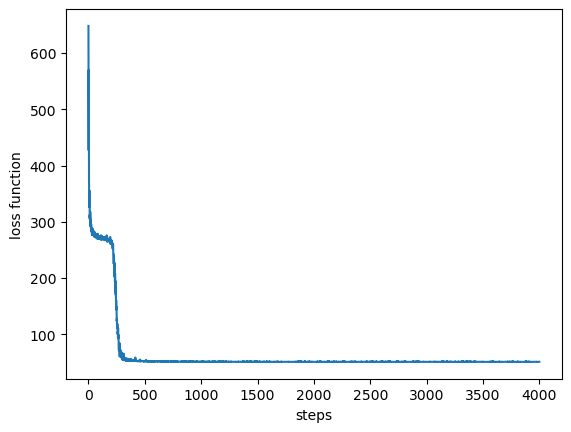

In [12]:
# plot loss function over number of training steps
plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('loss function')
plt.show()

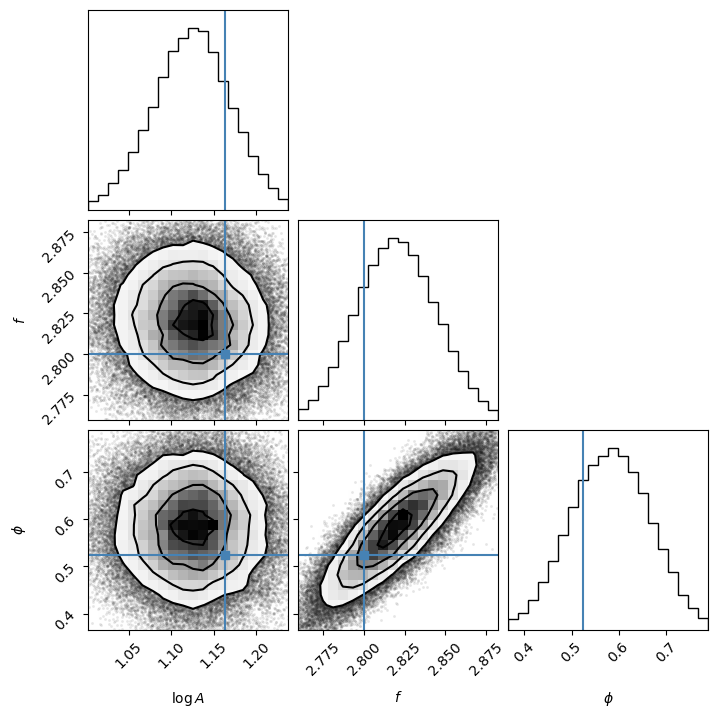

In [13]:
# samples from learned distribution
num_samples = 100_000
samples = np.array(flow.sample(key, (num_samples,)))

fig = corner.corner(samples,
                    truths=x_inj,
                    range=[0.99]*ndim,
                    labels=[r'$\log A$', r'$f$', r'$\phi$'])